In [1]:
import geopandas as gpd
import networkx as nx
import osmnx as ox
import shapely
import folium
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import pulp
from pulp import LpMaximize,LpMinimize, LpProblem, LpStatus, lpSum, LpVariable
from shapely.geometry import MultiPolygon, Polygon, Point, LineString
import pandas as pd
import networkit as nk
from tqdm.auto import tqdm
from pandarallel import pandarallel
import pygeos
# import rpyc

pandarallel.initialize(progress_bar=True)
tqdm.pandas()


TILES = "CartoDB positron"



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_1606/2270465399.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-u

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [10]:
G = nx.read_graphml('/Users/mvin/Desktop/mp_dev/public_space/DATA/walk_graph_spb_32636.graphml')

In [11]:
blocks = gpd.read_file('/Users/mvin/Desktop/mp_dev/public_space/DATA/House_vas.geojson')
ps = gpd.read_file('/Users/mvin/Desktop/mp_dev/public_space/DATA/potential_ps.geojson')

In [12]:
'''
Взято из библиотеки
'''


def get_nx2_nk_idmap(G_nx):
    idmap = dict((id, u) for (id, u) in zip(G_nx.nodes(), range(G_nx.number_of_nodes())))
    return idmap

def get_nk_attrs(G_nx):
    attrs = dict(
        (u, {"x": d[-1]["x"], "y": d[-1]["y"]}) 
        for (d, u) in zip(G_nx.nodes(data=True), range(G_nx.number_of_nodes()))
        )
    return attrs

def convert_nx2nk(G_nx, idmap=None, weight=None):

    if not idmap:
        idmap = get_nx2_nk_idmap(G_nx)
    n = max(idmap.values()) + 1
    edges = list(G_nx.edges())

    if weight:
        G_nk = nk.Graph(n, directed=G_nx.is_directed(), weighted=True)
        for u_, v_ in tqdm(edges):
                u, v = idmap[u_], idmap[v_]
                d = dict(G_nx[u_][v_])
                if len(d) > 1:
                    for d_ in d.values():
                            v__ = G_nk.addNodes(2)
                            u__ = v__ - 1
                            w = round(d_[weight], 1) if weight in d_ else 1
                            G_nk.addEdge(u, v, w)
                            G_nk.addEdge(u_, u__, 0)
                            G_nk.addEdge(v_, v__, 0)
                else:
                    d_ = list(d.values())[0]
                    w = round(d_[weight], 1) if weight in d_ else 1
                    G_nk.addEdge(u, v, w)
    else:
        G_nk = nk.Graph(n, directed=G_nx.is_directed())
        for u_, v_ in edges:
                u, v = idmap[u_], idmap[v_]
                G_nk.addEdge(u, v)

    return G_nk

In [13]:
G_nx = nx.convert_node_labels_to_integers(G)
G_nk = convert_nx2nk(G_nx, weight='time_min')

  0%|          | 0/875610 [00:00<?, ?it/s]

In [14]:
graph_df = pd.DataFrame.from_dict(dict(G_nx.nodes(data=True)), orient='index')


In [15]:
graph_gdf = gpd.GeoDataFrame(graph_df, geometry =gpd.points_from_xy(graph_df['x'], graph_df['y']), crs = 32636)
graph_gdf = graph_gdf.to_crs(32636)
blocks = blocks.to_crs(32636)
ps = ps.to_crs(32636)

In [16]:

blocks['x'] = blocks.centroid.x # добавляем столбец с x-координатами центроидов
blocks['y'] = blocks.centroid.y # добавляем столбец с y-координатами центроидов
houses_xy = np.asarray(blocks[['x', 'y']]) # преобразуем столбцы в массив numpy

ps['x'] = ps.centroid.x # добавляем столбец с x-координатами центроидов
ps['y'] = ps.centroid.y # добавляем столбец с y-координатами центроидов
PS_xy = np.asarray(ps[['x', 'y']]) # преобразуем столбцы в массив numpy

In [17]:
# blocks.drop(columns=['area'], inplace=True)
blocks.reset_index(inplace=True)
blocks.rename(columns={'index':'id'}, inplace=True)
blocks['centroids'] = blocks['geometry'].centroid
blocks.drop(columns=['geometry'], inplace=True)
blocks.rename(columns={'centroids':'geometry'}, inplace=True)

In [18]:
ps.reset_index(inplace=True)
ps.drop(columns=['id'], inplace=True)
ps.rename(columns={'index':'id'}, inplace=True)
ps['centroids'] = ps['geometry'].centroid
ps.drop(columns=['geometry'], inplace=True)
ps.rename(columns={'centroids':'geometry'}, inplace=True)

In [19]:
from_H = graph_gdf['geometry'].sindex.nearest(blocks['geometry'], return_distance = False, return_all = False)

In [20]:
from_ps = graph_gdf['geometry'].sindex.nearest(ps['geometry'], return_distance = False, return_all = False)

In [21]:
Matrix = pd.DataFrame(0, index = from_H[1], 
                        columns = from_ps[1])

In [22]:
def get_nk_distances(nk_dists, loc):

    target_nodes = loc.index
    source_node = loc.name
    distances = [nk_dists.getDistance(source_node, node) for node in target_nodes]

    return pd.Series(data = distances, index = target_nodes)


nk_dists = nk.distance.SPSP(G_nk, sources = Matrix.index.values).run()

Matrix =  Matrix.apply(lambda x: get_nk_distances(nk_dists, x), axis =1)

In [23]:
Matrix.index = blocks['id']
Matrix.columns = ps['area_type']

In [24]:
df = Matrix
df

area_type,large,medium,small,small,large,medium,medium,medium,medium,large,...,small,large,large,large,large,large,large,large,large,large
id,,,,,,,,,,,,,,,,,,,,,
0,66.0,68.0,66.0,66.0,68.0,71.0,70.0,69.0,76.0,66.0,...,36.0,39.0,12.0,73.0,46.0,66.0,67.0,46.0,8.0,78.0
1,67.0,69.0,67.0,67.0,69.0,72.0,71.0,70.0,77.0,67.0,...,37.0,41.0,14.0,75.0,47.0,67.0,68.0,47.0,10.0,79.0
2,64.0,66.0,64.0,64.0,66.0,69.0,68.0,67.0,74.0,64.0,...,34.0,42.0,16.0,76.0,44.0,64.0,65.0,44.0,12.0,76.0
3,61.0,63.0,61.0,61.0,63.0,66.0,65.0,64.0,71.0,61.0,...,31.0,41.0,15.0,75.0,41.0,61.0,62.0,41.0,13.0,73.0
4,63.0,65.0,63.0,63.0,65.0,68.0,67.0,66.0,73.0,63.0,...,33.0,41.0,17.0,75.0,43.0,63.0,64.0,43.0,13.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,38.0,60.0,58.0,58.0,39.0,37.0,41.0,40.0,41.0,32.0,...,35.0,70.0,69.0,60.0,58.0,12.0,18.0,32.0,68.0,30.0
1137,35.0,57.0,55.0,55.0,36.0,34.0,38.0,37.0,38.0,29.0,...,32.0,69.0,66.0,57.0,57.0,9.0,21.0,29.0,65.0,27.0
1138,38.0,60.0,58.0,58.0,39.0,37.0,41.0,40.0,41.0,32.0,...,34.0,71.0,69.0,60.0,59.0,12.0,20.0,31.0,68.0,30.0


In [25]:
def replace_values(col):
    # Получаем название столбца
    name = col.name
    # Если название large, то заменяем все значения >= 20 на 0 и остальные на 1
    if name == 'large':
        return col.apply(lambda x: 0 if x >= 20 else 1)
    # Если название medium, то заменяем все значения >= 10 на 0 и остальные на 1
    elif name == 'medium':
        return col.apply(lambda x: 0 if x >= 10 else 1)
    # Если название small, то заменяем все значения >=5 на 0 и остальные на 1
    elif name == 'small':
        return col.apply(lambda x: 0 if x >=5 else 1)

In [26]:
df = df.apply(replace_values)
df.columns = ps['id']
df

id,0,1,2,3,4,5,6,7,8,9,...,362,363,364,365,366,367,368,369,370,371
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [27]:
df.to_csv('matrica.csv')  

In [28]:
W_ij = np.array(df).astype(int)
W_ij,W_ij.flatten().sum()

(array([[0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 10953)

In [29]:
houses = np.zeros(W_ij.shape[0])
houses

for i in range (0,len(houses)):
    if W_ij[i].sum() > 0:
        houses[i] += 1
        
houses.sum()

1103.0

In [30]:
houses_cov = houses.sum()*4
houses_cov

4412.0

In [31]:
n = len(blocks)
m = len(ps)

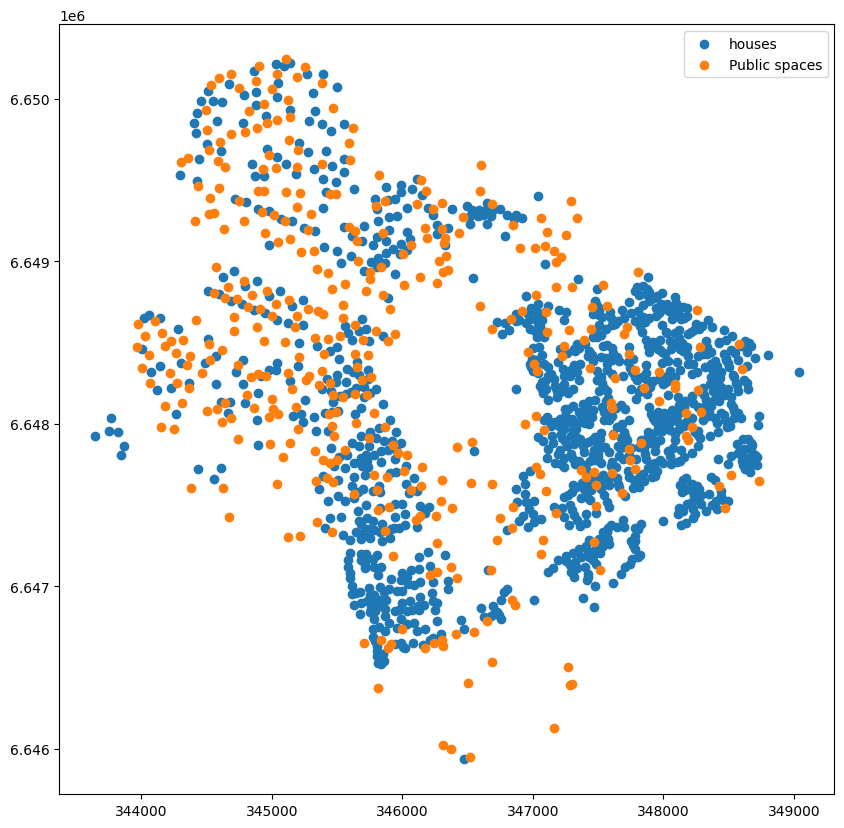

In [33]:
fig = plt.figure(figsize = (10,10))

plt.scatter(houses_xy[:,0],houses_xy[:,1],label = 'houses')
plt.scatter(PS_xy[:,0],PS_xy[:,1],label = 'Public spaces')

#plt.scatter(PS_xy[:,0],PS_xy[:,1], s=(r), facecolors='none', edgecolors='r')

#print('R = ',r)
plt.legend()
plt.show()

Задача: имеется набор мест под общественные пространства (ОП), ОП могут быть нескольких типов (спорт, наука, культура и тд.). Есть набор домов, которые необходимо удовлетворить с помощью ОП, дом считается удовлетворенным ОП выбранного типа, если в заданном радиусе от него находится ОП выбранноготипа.

Обозначения:

$n$ - коичество домов (итератор - i)

$m$ - количество мест (итератор - j)

$k$ - количество типов ОП (итератор - l)

$r$ - радиус в котором ОП оказывают влияния на дома 

$W$ - матрица расстояний от домов до ОП

$M$ - большое число по сравнению с числом ОП

$p$ - число ОП которое можно открыть



$V$ - матрица выбранных расположений ОП, бинарная, размерности $(m\times k)$

$hp (i,k) = \sum\limits_{j=1}^{m} (W_j(i)*V_j(k))$ - матрица покрытия  домов ОП-ми, целочисленная , размерности $(n\times k)$

$Hp (i,k):$ {1 если $hp(i,k)	\geqslant 1$; 0 если $hp(i,k)< 1$} - матрица покрытия  домов ОП-ми, бинарная , размерности $(n\times k)$

функция оптимизации:

$maximization \sum\limits_{l=1}^{k}\sum\limits_{i=1}^{n} Hp_{il}$

ограничения:

$\sum\limits_{l=1}^{k}\sum\limits_{j=1}^{m} V_{jl} 	\leqslant p $ разрешено сделать не более  p новых ОП


$\sum\limits_{l=1}^{k} V_{jl} 	\leqslant 1$:       в 1 месте есть ОП только 1 типа

In [38]:
model = LpProblem(name="mini_port", sense=LpMaximize)

M = 1000000
p = 60
k = 4  #кол-во типов ОП

eps = 0.00001
V = pulp.LpVariable.matrix(name = 'V', indices = [f'{l:02}_{j:03}' for j in range(m) for l in range(k)], cat = 'Binary')

H_p = pulp.LpVariable.matrix(name = 'H', indices = [f'{i:03}_{l:02}' for i in range(n) for l in range(k)], cat = 'Binary')
h_p = pulp.LpVariable.matrix(name = 'h', indices = [f'{i:03}_{l:02}' for i in range(n) for l in range(k)], cat = 'Integer')

V = np.array(V).reshape(m,k)
H_p = np.array(H_p).reshape(n,k)
h_p = np.array(h_p).reshape(n,k)

for l in range(k):
    for i in range(n):
        h_p[i,l] = (W_ij[i,:]*V[:,l]).sum()

for l in range(k):
    for i in range(n):
        model += h_p[i,l]-1 <= M*H_p[i,l], f'h{i}_{l}>=1 => H{i}_{l} = 1'
        model += h_p[i,l] >= H_p[i,l]-eps, f'h{i}_{l}<1 => H{i}_{l} = 0'

for j in range(m):
    model += lpSum(V[j,l] for l in range(0,k)) <= 1, f'cant be 2 PS in 1 place{j}'
    
model += lpSum(V[j,l] for j in range(0,m) for l in range(k) ) <= p, f'max p constraint'
    

obj_func = lpSum(H_p) - lpSum(V)/M
model += obj_func

In [39]:
#model

In [40]:
from tqdm import tqdm
tqdm.pandas()
print('H')
model.solve(pulp.getSolver('PULP_CBC_CMD'))

status =  LpStatus[model.status]
print('N')

print(status)

print("Total Cost:", model.objective.value())
# Decision Variables

res = []
for v in model.variables():
    try:
        print(v.name,"=", v.value())
        res.append(v.value())
    except:
        print("error couldnt find value")
        pass

H


использовано ОП  = 90.0 из 90 возможных
удовлетворено: 3953.9999100000105 ячеек домов из 4412.0 ячеек домов


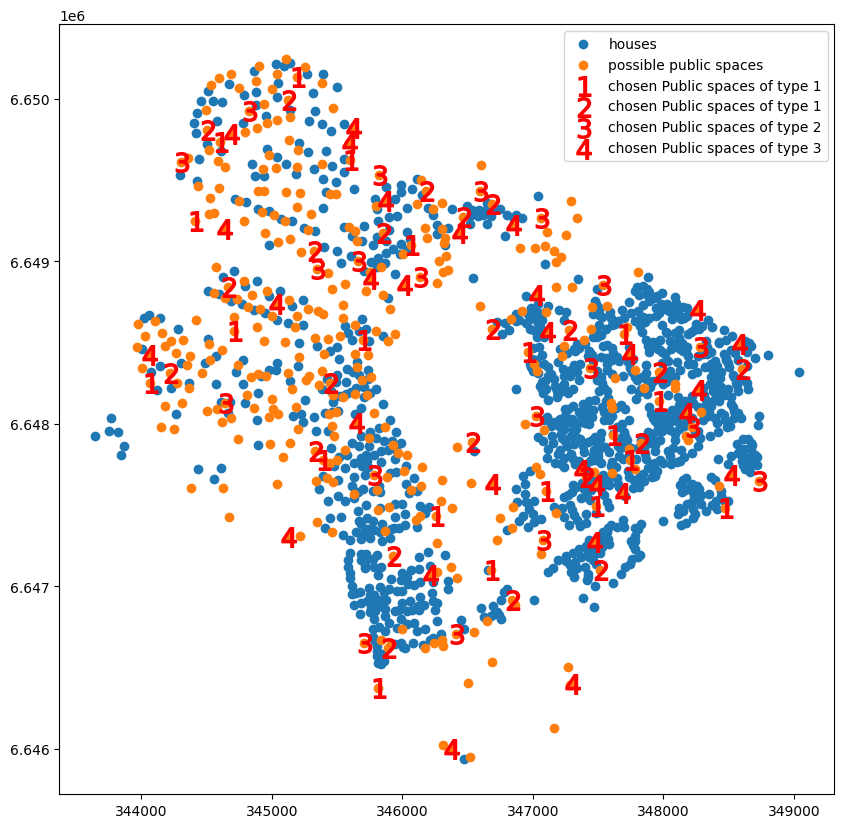

In [ ]:
fig = plt.figure(figsize = (10,10))

plt.scatter(houses_xy[:,0],houses_xy[:,1],label = 'houses')
plt.scatter(PS_xy[:,0],PS_xy[:,1],label = 'possible public spaces')

mark = ["*","P","d","$PS_4$"]
mark = ["$1$","$2$","$3$","$4$"]
plt.scatter(PS_xy[np.array(res[-m:]).astype(bool)][:,0],PS_xy[np.array(res[-m:]).astype(bool)][:,1],
            label = f'chosen Public spaces of type 1',c = 'red',marker = "$1$",s = 200)
for l in range(1,4):
    plt.scatter(PS_xy[np.array(res[-m*(l+1):-l*m]).astype(bool)][:,0],PS_xy[np.array(res[-m*(l+1):-l*m]).astype(bool)][:,1],
                marker = mark[l], label = f'chosen Public spaces of type {l}',c = 'red',s = 200)


#plt.scatter(PS_xy[:,0],PS_xy[:,1], s=(4*r*square_side*square_side*int(fig.dpi))^2, facecolors='none', edgecolors='r')

#print('influence radius: R = ',r)
print(f'использовано ОП  = {sum(res[-m*k:])} из {p} возможных')
print("удовлетворено:", model.objective.value(),f'ячеек домов из {houses_cov} ячеек домов')
plt.legend(bbox_to_anchor=(1., 1))
plt.show()